# **BirdCLEF 2025 Data Preprocessing Notebook**

In [1]:
import os
import cv2
import math
import time
import librosa
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import os
import numpy as np
from datetime import datetime
import pytz
import torch
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedGroupKFold

from joblib import Parallel, delayed

from importlib import reload

from module import config_lib, utils_lib

In [2]:
class DatasetConfig:
    def __init__(self, kaggle_notebook=False, debug=False):
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.PROCESSED_DIR = ""
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.model_path = '/kaggle/input/birdclef-2025-0330'
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.models_dir = "../models/" # 全modelの保存先
            self.model_path = self.models_dir # 各モデルの保存先．学習時に動的に変更．
            self.RAW_DIR = '../data/raw/'
            self.PROCESSED_DIR = '../data/processed/'


        # ===== Audio Settings =====
        self.FS = 32000
        self.TARGET_DURATION = 5 # データセット作成時のウィンドウサイズ
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 512
        self.N_MELS = 148
        self.FMIN = 20
        self.FMAX = 16000
        self.N_MAX = 50 if self.debug else None        
        self.N_JOBS = 16  # 並列処理のスレッド数 16くらいでいい
        self.N_JOBS_DURATION = 47
        
        self.LOAD_ENGINE = 'torchaudio'  # librosa or torchaudio
        self.SKIP_RESIZE = False  # resizeしないならTrue
        self.seed = 42
        self.n_fold = 5
        self.num_rare_samples = 10 # これ以下のサンプル数のspeciesはrare speciesとして扱う
        self.is_crop_aug = False
        self.num_prune_samples = 1000 # サンプル数をこれ以下にprune

In [3]:
config = DatasetConfig(kaggle_notebook=False, debug=False)

In [4]:
utils_lib.set_seed(config.seed)

In [ ]:
import os
import numpy as np
import cv2
import pickle

# === 入出力パス ===
mels_save_dir = "../data/processed/mel_safezone1000_head_hoplength512"
input_path = os.path.join(mels_save_dir, "birdclef2025_melspec_5sec_256_256.npy")
imagenet_output_path = os.path.join(mels_save_dir, "birdclef2025_melspec_5sec_256_256_rgb_imagenetnorm.npy")

# === ImageNet 正規化定数 ===
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape((1, 1, 3))
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape((1, 1, 3))

# === 読み込み ===
with open(input_path, 'rb') as f:
    mels = np.load(f, allow_pickle=True).item()

# === ステップ①：モノクロ → RGB化（float32, [0.0–1.0]）
def convert_to_rgb(mel_dict, colormap=cv2.COLORMAP_TURBO):
    rgb_dict = {}
    for key, melspec in mel_dict.items():
        normed = cv2.normalize(melspec, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        rgb = cv2.applyColorMap(normed, colormap)  # (H, W, 3), uint8
        rgb = rgb.astype(np.float32) / 255.0  # → float32 [0–1]
        rgb_dict[key] = rgb  # shape: (H, W, 3)
    return rgb_dict

# === ステップ②：ImageNet正規化 + CHW整形
def imagenet_normalize_rgb(rgb_dict):
    norm_dict = {}
    for key, rgb in rgb_dict.items():
        normed = (rgb - IMAGENET_MEAN) / IMAGENET_STD  # shape: (H, W, 3)
        chw = np.transpose(normed, (2, 0, 1))  # → (3, H, W)
        norm_dict[key] = chw
    return norm_dict

# === 実行フェーズ ===
# Step 1: RGB化
rgb_dict = convert_to_rgb(mels, colormap=cv2.COLORMAP_TURBO)

# Step 2: ImageNet正規化
imagenet_dict = imagenet_normalize_rgb(rgb_dict)
imagenet_dict = np.array(imagenet_dict, dtype=object)  # dtype: object

# # 保存（ステップ2の出力）
# with open(imagenet_output_path, 'wb') as f:
#     pickle.dump(imagenet_dict, f, protocol=5)

# # === ログ確認 ===
# sample_key = next(iter(rgb_dict))
# print(f"✅ ImageNet-normalized saved: {imagenet_output_path} → shape: {imagenet_dict[sample_key].shape}")

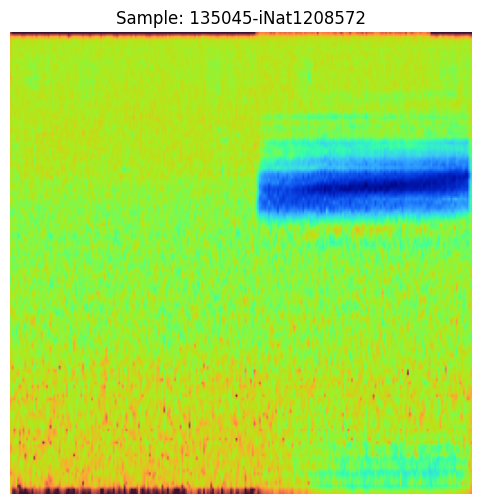

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# === 正規化を戻す関数 ===
def denormalize_imagenet(tensor_chw):
    """
    CHW形式のImageNet正規化済み画像をRGB画像(H, W, 3)に戻す
    """
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    rgb_chw = tensor_chw * std + mean  # shape: (3, H, W)
    rgb_hwc = np.transpose(rgb_chw, (1, 2, 0))  # shape: (H, W, 3)
    rgb_hwc = np.clip(rgb_hwc, 0, 1)  # 安全のためclip
    return rgb_hwc

# === 表示用にサンプルを1つ取り出す ===
sample_key = "135045-iNat1208572"
tensor = imagenet_dict[sample_key]  # shape: (3, H, W)
# tensor = mels[sample_key]  # shape: (3, H, W)
rgb_image = denormalize_imagenet(tensor)

# === matplotlibで可視化 ===
plt.figure(figsize=(8, 6))
plt.imshow(rgb_image, origin='lower')  # これで通常の向きになる
plt.title(f"Sample: {sample_key}")
plt.axis("off")
plt.show()

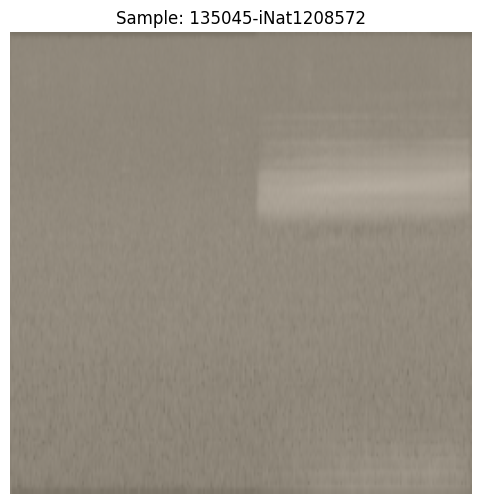

In [54]:
sample_key = "135045-iNat1208572"
tensor = mels[sample_key]  # shape: (3, H, W)
# tensor = mels[sample_key]  # shape: (3, H, W)
rgb_image = denormalize_imagenet(tensor)

# === matplotlibで可視化 ===
plt.figure(figsize=(8, 6))
plt.imshow(rgb_image, origin='lower')  # これで通常の向きになる
plt.title(f"Sample: {sample_key}")
plt.axis("off")
plt.show()

In [55]:
utils_lib.play_audio("135045/iNat1208572.ogg",config.train_datadir)

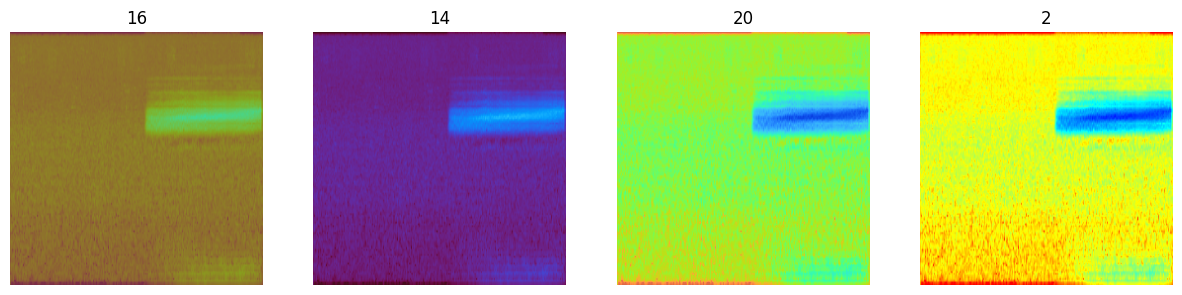

In [51]:
import matplotlib.pyplot as plt

def visualize_colormaps(melspec, colormaps):
    fig, axes = plt.subplots(1, len(colormaps), figsize=(15, 4))
    for ax, cmap_name in zip(axes, colormaps):
        colored = cv2.applyColorMap(cv2.normalize(melspec, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8), cmap_name)
        ax.imshow(colored, origin='lower')
        ax.set_title(cmap_name)
        ax.axis('off')
    plt.show()

visualize_colormaps(rgb_image, [
    cv2.COLORMAP_VIRIDIS,
    cv2.COLORMAP_INFERNO,
    cv2.COLORMAP_TURBO,
    cv2.COLORMAP_JET
])

In [ ]:
# 向きはあってそう